# 1. Config & Data Load

In [68]:
import os
import numpy as np
import pandas as pd
import mlflow
import plotly.express as px
import plotly.io as pio

# --- Deterministic setup ---
SEED = 108
np.random.seed(SEED)

# --- Paths ---
DATA_PATH = r"C:\Users\argon\Documents\Desktop Prime\MS Business Analytics\Fall Semester\Marketing Analytics\Modified_Telco_Customer_Churn_Updated.csv"
MLFLOW_DIR = "mlruns_telco"

# --- Ensure MLflow folder exists ---
os.makedirs(MLFLOW_DIR, exist_ok=True)

# --- MLflow setup (Windows-safe local URI) ---
mlflow.set_tracking_uri("file:mlruns")
mlflow.set_experiment("TelcoChurn_Baseline")

print("MLflow tracking URI:", mlflow.get_tracking_uri())
print("Experiment set successfully.\n")

# --- Load dataset ---
df_raw = pd.read_csv(DATA_PATH)

# --- Coerce numeric suspects ---
for col in ["MonthlyCharges", "TotalCharges"]:
    if col in df_raw.columns:
        df_raw[col] = pd.to_numeric(df_raw[col], errors="coerce")

# --- Ensure target is integer 0/1 ---
if df_raw["Churn"].dtype != "int64":
    df_raw["Churn"] = df_raw["Churn"].astype(int)

# --- Snapshot summary ---
print(f"Shape: {df_raw.shape}")
print("Unique customers:", df_raw["customerID"].nunique())
print("Duplicate IDs:", df_raw.duplicated("customerID").sum())
df_raw.head(3)


MLflow tracking URI: file:mlruns
Experiment set successfully.

Shape: (7043, 22)
Unique customers: 7043
Duplicate IDs: 0


customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG       0              0        1           0       1   
1  5575-GNVDE       1              0        0           0      34   
2  3668-QPYBK       1              0        0           0       2   

   PhoneService  MultipleLines InternetService  OnlineSecurity  ...  \
0             0              0             DSL               0  ...   
1             1              0             DSL               1  ...   
2             1              0             DSL               1  ...   

   TechSupport  StreamingTV  StreamingMovies        Contract  \
0            0            0                0  Month-to-month   
1            0            0                0        One year   
2            0            0                0  Month-to-month   

   PaperlessBilling     PaymentMethod  TotalCharges Churn  AvgChargesPerMonth  \
0                 1  Electronic check         29.85     0           29.850000   
1                 0      Mailed check       1889.50     0           55.573529   
2                 1      Mailed check        108.15     1           54.075000   

   MonthlyCharges  
0           29.85  
1           56.95  
2           53.85  

[3 rows x 22 columns]

# 2. EDA I

In [69]:
# Build schema_report with column-name index to ensure alignment
schema_report = pd.DataFrame(index=df_raw.columns)
schema_report["dtype"] = df_raw.dtypes.astype(str)
schema_report["%missing"] = (df_raw.isna().mean() * 100).round(2)
schema_report["cardinality"] = df_raw.nunique(dropna=True)
schema_report = schema_report.reset_index().rename(columns={"index": "column"})

# Show the first rows
schema_report

column    dtype  %missing  cardinality
0           customerID   object       0.0         7043
1               gender    int64       0.0            2
2        SeniorCitizen    int64       0.0            2
3              Partner    int64       0.0            2
4           Dependents    int64       0.0            2
5               tenure    int64       0.0           73
6         PhoneService    int64       0.0            2
7        MultipleLines    int64       0.0            2
8      InternetService   object       0.0            3
9       OnlineSecurity    int64       0.0            2
10        OnlineBackup    int64       0.0            2
11    DeviceProtection    int64       0.0            2
12         TechSupport    int64       0.0            2
13         StreamingTV    int64       0.0            2
14     StreamingMovies    int64       0.0            2
15            Contract   object       0.0            3
16    PaperlessBilling    int64       0.0            2
17       PaymentMethod   object       0.0            4
18        TotalCharges  float64       0.0         6531
19               Churn    int64       0.0            2
20  AvgChargesPerMonth  float64       0.0         6545
21      MonthlyCharges  float64       0.0         1542

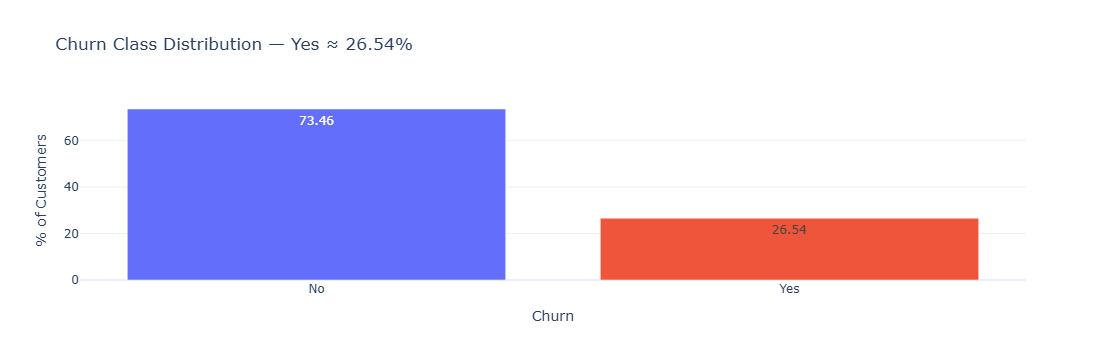

In [70]:
# --- Churn distribution (improved version) ---
import plotly.express as px

# Map churn values to readable labels
churn_df = (
    df_raw["Churn"]
    .replace({0: "No", 1: "Yes"})
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .rename_axis("Churn")
    .reset_index(name="Percent")
)


fig_churn = px.bar(
    churn_df,
    x="Churn",
    y="Percent",
    color="Churn",
    text="Percent",
    title=f"Churn Class Distribution — Yes ≈ {(df_raw['Churn'].mean() * 100).round(2)}%",
    labels={"Churn": "Churn", "Percent": "% of Customers"},
    template="plotly_white",
)

# Cosmetic polish
fig_churn.update_layout(showlegend=False, yaxis_title="% of Customers")

fig_churn.show()


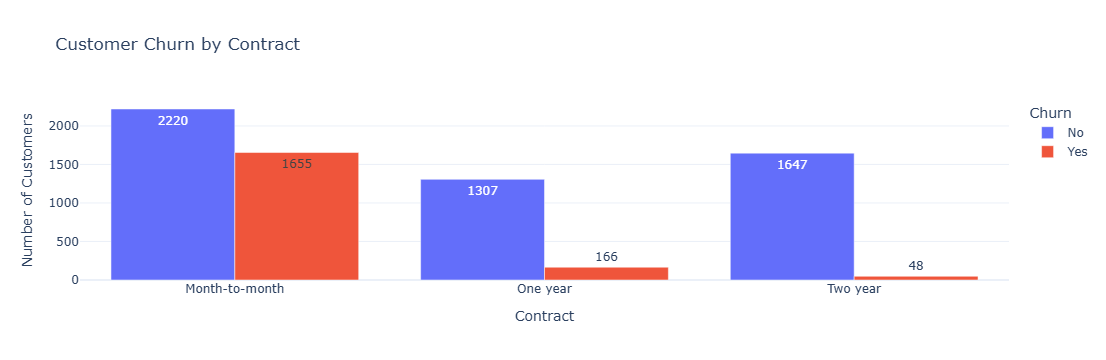

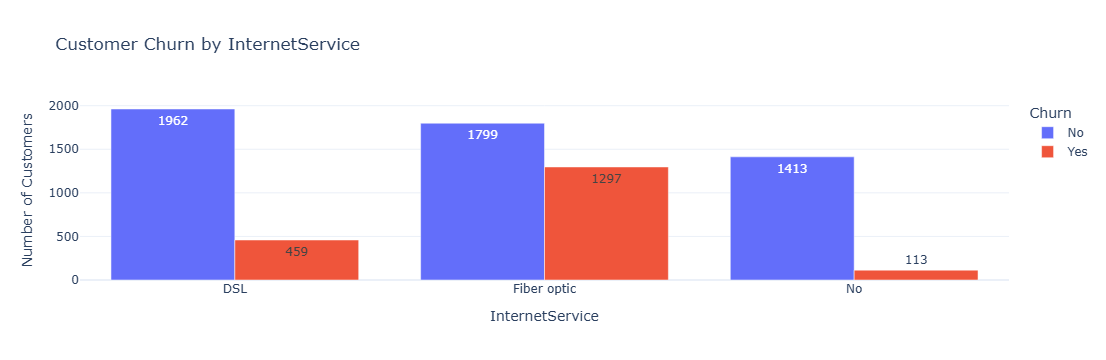

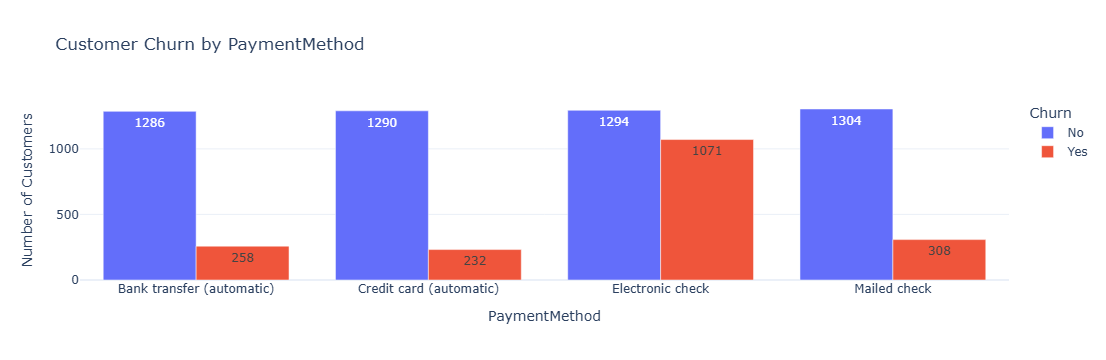

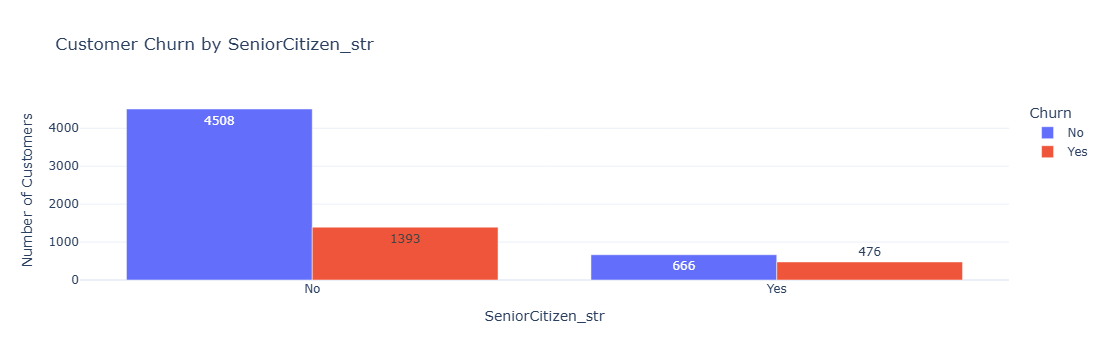

In [71]:
# --- Categorical churn plots ---
import plotly.express as px

# Map binary columns to "Yes"/"No" strings for readability
binary_map = {0: "No", 1: "Yes"}
df_plot = df_base.copy()
for col in ["Partner", "Dependents", "SeniorCitizen", "PhoneService",
            "MultipleLines", "OnlineSecurity", "OnlineBackup",
            "DeviceProtection", "TechSupport", "StreamingTV",
            "StreamingMovies", "PaperlessBilling", "Churn"]:
    if col in df_plot.columns:
        df_plot[col + "_str"] = df_plot[col].map(binary_map)

def plot_cat_bar(feature):
    counts = df_plot.groupby([feature, "Churn_str"]).size().reset_index(name="Count")
    fig = px.bar(
        counts,
        x=feature,
        y="Count",
        color="Churn_str",
        barmode="group",
        text_auto=True,
        category_orders={"Churn_str": ["No", "Yes"]},
        title=f"Customer Churn by {feature}"
    )
    fig.update_layout(
        xaxis_title=feature,
        yaxis_title="Number of Customers",
        legend_title_text="Churn",
        template="plotly_white"
    )
    fig.show()

# Example: run a few key plots
for cat in ["Contract", "InternetService", "PaymentMethod", "SeniorCitizen_str"]:
    plot_cat_bar(cat)


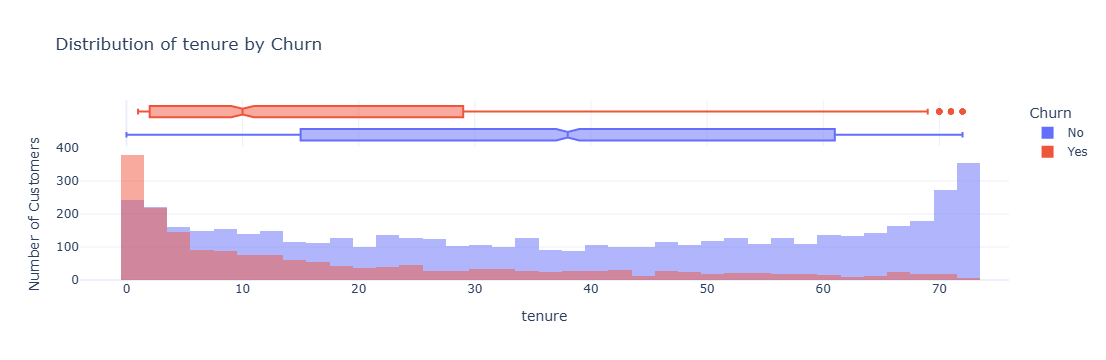

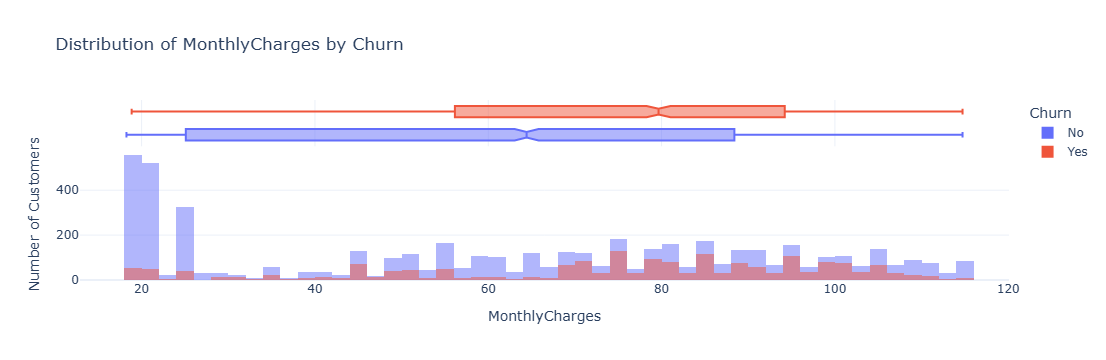

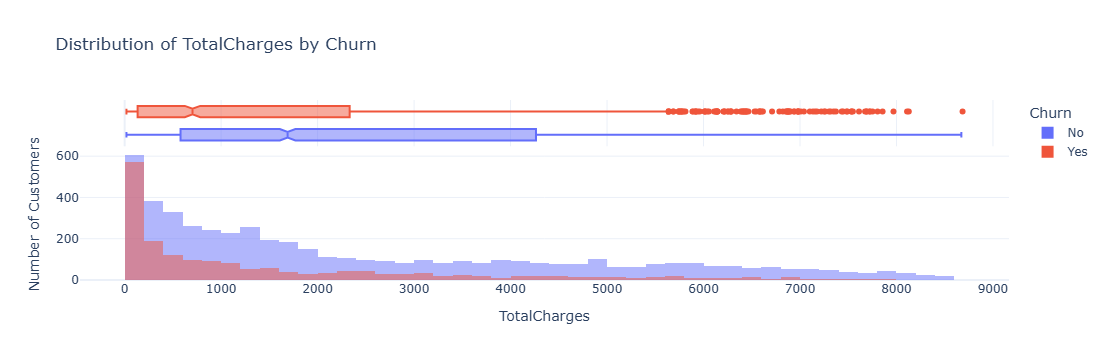

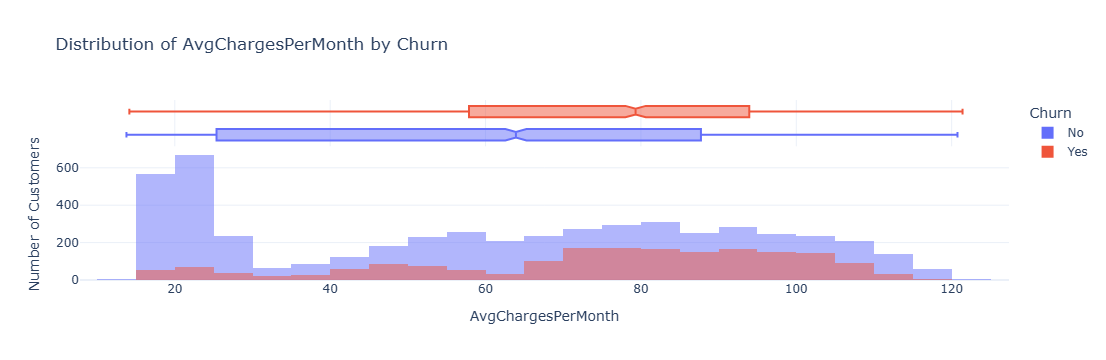

In [72]:
# --- Numeric churn overlays ---
def plot_num_hist(feature):
    fig = px.histogram(
        df_plot,
        x=feature,
        color="Churn_str",
        nbins=50,
        marginal="box",
        barmode="overlay",
        category_orders={"Churn_str": ["No", "Yes"]},
        title=f"Distribution of {feature} by Churn"
    )
    fig.update_layout(
        xaxis_title=feature,
        yaxis_title="Number of Customers",
        legend_title_text="Churn",
        template="plotly_white"
    )
    fig.show()

for num in ["tenure", "MonthlyCharges", "TotalCharges", "AvgChargesPerMonth"]:
    plot_num_hist(num)


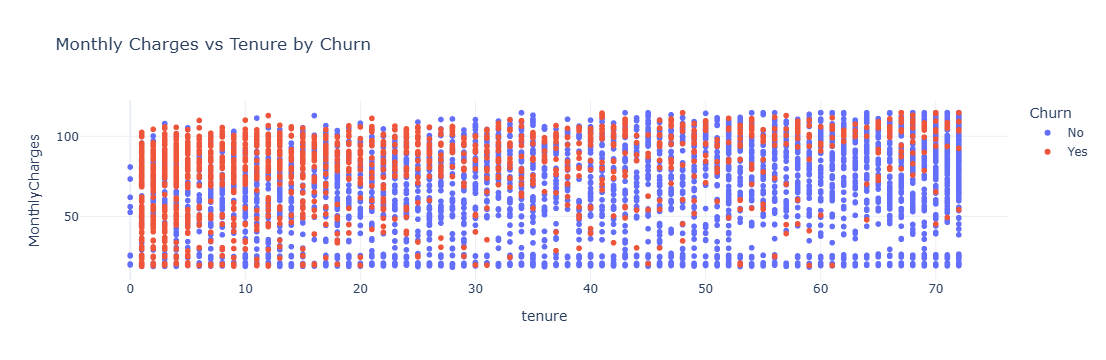

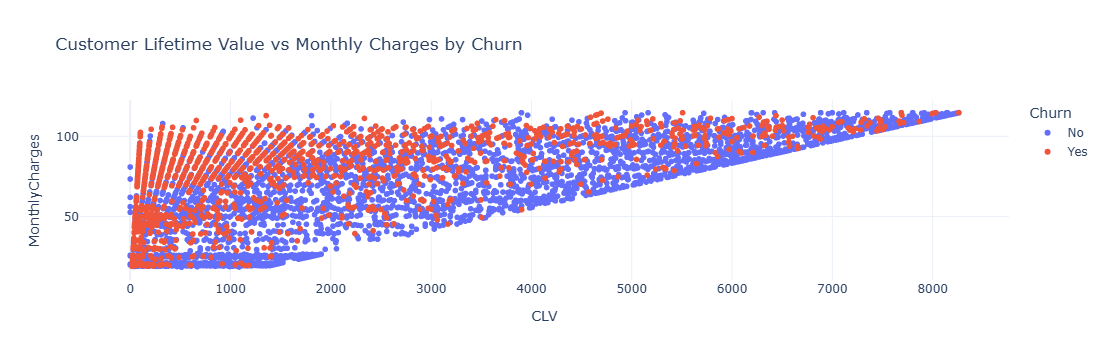

In [73]:
# --- Scatter plots ---
df_plot["CLV"] = df_plot["tenure"] * df_plot["MonthlyCharges"]

def plot_scatter(x, y, title=None):
    fig = px.scatter(
        df_plot,
        x=x,
        y=y,
        color="Churn_str",
        hover_data=["Contract", "PaymentMethod"],
        category_orders={"Churn_str": ["No", "Yes"]},
        title=title or f"{y} vs {x} by Churn",
        template="plotly_white"
    )
    fig.update_layout(
        xaxis_title=x,
        yaxis_title=y,
        legend_title_text="Churn"
    )
    fig.show()

plot_scatter("tenure", "MonthlyCharges", "Monthly Charges vs Tenure by Churn")
plot_scatter("CLV", "MonthlyCharges", "Customer Lifetime Value vs Monthly Charges by Churn")


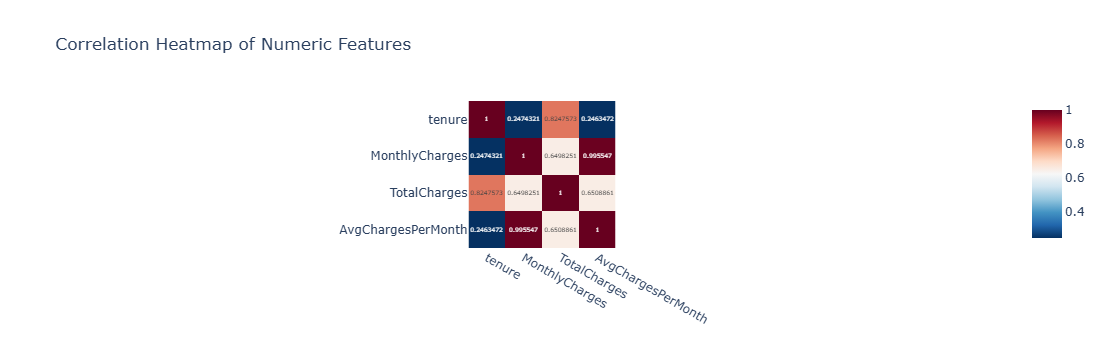

In [74]:
# --- Correlation heatmap ---
import plotly.express as px

num_cols = ["tenure", "MonthlyCharges", "TotalCharges", "AvgChargesPerMonth"]
corr_matrix = df_plot[num_cols].corr()

fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    title="Correlation Heatmap of Numeric Features",
    template="plotly_white"
)
fig.update_layout(xaxis_title="", yaxis_title="")
fig.show()


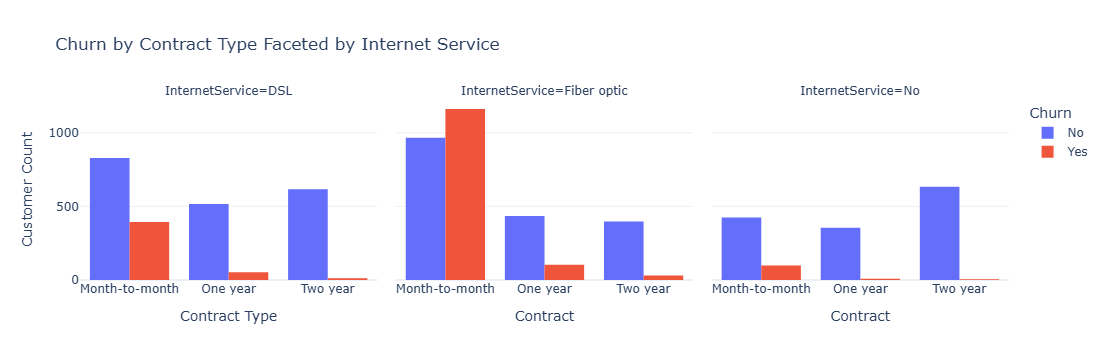

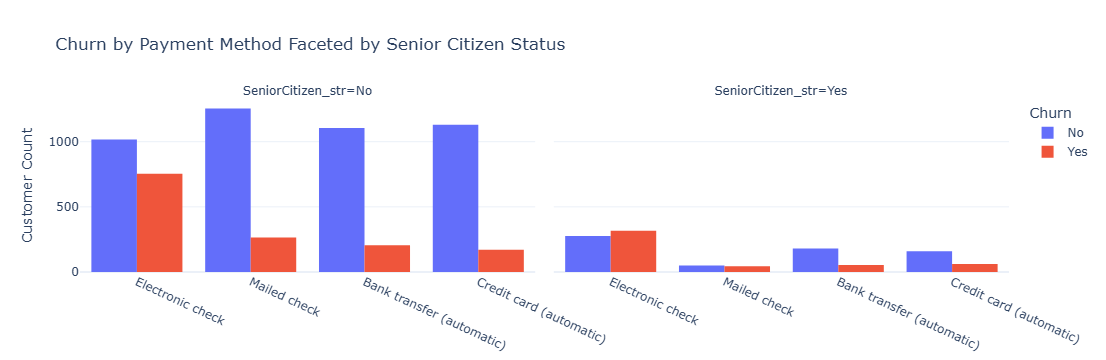

In [75]:
# Use df_plot from earlier (with mapped 'Churn_str')
# Ensure it exists — otherwise remap
if "Churn_str" not in df_plot.columns:
    df_plot["Churn_str"] = df_plot["Churn"].map({0: "No", 1: "Yes"})

# --- 1. Contract × InternetService facet ---
fig1 = px.histogram(
    df_plot,
    x="Contract",
    color="Churn_str",
    facet_col="InternetService",
    barmode="group",
    category_orders={
        "Churn_str": ["No", "Yes"],
        "Contract": ["Month-to-month", "One year", "Two year"]
    },
    title="Churn by Contract Type Faceted by Internet Service",
    template="plotly_white"
)
fig1.update_layout(
    showlegend=True,
    legend_title_text="Churn",
    xaxis_title="Contract Type",
    yaxis_title="Customer Count",
)
fig1.show()

# --- 2️. PaymentMethod × SeniorCitizen facet ---
fig2 = px.histogram(
    df_plot,
    x="PaymentMethod",
    color="Churn_str",
    facet_col="SeniorCitizen_str",
    barmode="group",
    category_orders={"Churn_str": ["No", "Yes"]},
    title="Churn by Payment Method Faceted by Senior Citizen Status",
    template="plotly_white"
)
fig2.update_xaxes(title=None, tickangle=25)
fig2.update_layout(
    showlegend=True,
    legend_title_text="Churn",
    yaxis_title="Customer Count",
)
fig2.show()

# 3. Cleaning and Imputation

In [76]:
df_base = df_raw.copy()

# --- 0) Tenure bins (ensure 0 months included) ---
bins   = [0, 12, 24, 36, 48, 60, np.inf]
labels = ["0-1y", "1-2y", "2-3y", "3-4y", "4-5y", "5y+"]
df_base["tenure_bin"] = pd.cut(
    df_base["tenure"], bins=bins, labels=labels, right=True, include_lowest=True
)

# --- 1) Coerce numerics, then standardize ±inf -> NaN ---
num_cols = ["MonthlyCharges", "AvgChargesPerMonth", "TotalCharges"]
for col in num_cols:
    if col in df_base.columns:
        df_base[col] = pd.to_numeric(df_base[col], errors="coerce")
df_base[num_cols] = df_base[num_cols].replace([np.inf, -np.inf], np.nan)

# --- 2) Recompute AvgChargesPerMonth where feasible (tenure > 0) ---
if {"TotalCharges", "tenure", "AvgChargesPerMonth"}.issubset(df_base.columns):
    mask_recompute = df_base["AvgChargesPerMonth"].isna() & df_base["TotalCharges"].notna() & (df_base["tenure"] > 0)
    df_base.loc[mask_recompute, "AvgChargesPerMonth"] = (
        df_base.loc[mask_recompute, "TotalCharges"] / df_base.loc[mask_recompute, "tenure"]
    ).round(2)

# --- 3) Tenure-bin median imputation (fallback = global median) ---
impute_log = []
for col in num_cols:
    if col not in df_base.columns:
        continue
    global_med = df_base[col].median()
    bybin_med  = df_base.groupby("tenure_bin", observed=True)[col].transform("median")
    before = int(df_base[col].isna().sum())
    df_base[col] = df_base[col].fillna(bybin_med).fillna(global_med)
    after = int(df_base[col].isna().sum())
    impute_log.append((col, before, after))

# --- 4) Final sanity: enforce finiteness ---
if not np.isfinite(df_base[num_cols].to_numpy(dtype="float64")).all():
    # as a last guard, replace any lingering non-finite with global medians
    for col in num_cols:
        med = df_base[col].median()
        df_base[col] = np.where(np.isfinite(df_base[col].astype("float64")), df_base[col], med)

# --- 5) Verification ---
print("Imputation Summary (missing before → after):")
for col, b, a in impute_log:
    print(f"{col:<20} {b:>6} → {a:<6}")
print("\nRow count preserved:", len(df_base), "| Unique customerID:", df_base["customerID"].nunique())

# Quick finiteness checks
print("\nMeans (should all be finite):")
print(df_base[num_cols].mean(numeric_only=True))
print("\nMax values (should be finite):")
print(df_base[num_cols].max(numeric_only=True))

# Spot-check preview
df_base[["customerID", "tenure", "tenure_bin", "MonthlyCharges", "AvgChargesPerMonth", "TotalCharges"]].describe()

Imputation Summary (missing before → after):
MonthlyCharges            0 → 0     
AvgChargesPerMonth       11 → 0     
TotalCharges              0 → 0     

Row count preserved: 7043 | Unique customerID: 7043

Means (should all be finite):
MonthlyCharges          64.747559
AvgChargesPerMonth      64.788101
TotalCharges          2283.300441
dtype: float64

Max values (should be finite):
MonthlyCharges         114.729
AvgChargesPerMonth     121.400
TotalCharges          8684.800
dtype: float64


tenure  MonthlyCharges  AvgChargesPerMonth  TotalCharges
count  7043.000000     7043.000000         7043.000000   7043.000000
mean     32.371149       64.747559           64.788101   2283.300441
std      24.559481       30.066050           30.163664   2265.000258
min       0.000000       18.250000           13.775000     18.800000
25%       9.000000       35.500000           36.255000    402.225000
50%      29.000000       70.350000           70.300000   1400.550000
75%      55.000000       89.850000           90.174158   3786.600000
max      72.000000      114.729000          121.400000   8684.800000

# 4. Feature Engineering

In [77]:
import numpy as np
import pandas as pd

df_feat = df_base.copy()

# --- v1: Baseline engineered features ---
# Number of add-on services (each 1 = subscribed)
addon_cols = [
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
]
df_feat["NumAddOns"] = df_feat[addon_cols].sum(axis=1)

# Family indicator: partner or dependents
df_feat["FamilySupport"] = ((df_feat["Partner"] == 1) | (df_feat["Dependents"] == 1)).astype(int)

# --- v2: Curated extensions ---
df_feat["log_tenure"] = np.log1p(df_feat["tenure"])
df_feat["tenure_sqrt"] = np.sqrt(df_feat["tenure"])

# Interaction: M2M × tenure_bin → high churn risk proxy
df_feat["M2M_x_tenurebin"] = ((df_feat["Contract"] == "Month-to-month") & (df_feat["tenure_bin"].isin(["0-1y", "1-2y"]))).astype(int)

# Relative price shock — gap between monthly and average charges
df_feat["PriceShockPct"] = ((df_feat["MonthlyCharges"] - df_feat["AvgChargesPerMonth"]) / (df_feat["AvgChargesPerMonth"] + 1e-6)).round(3)

# Absolute charge gap
df_feat["ChargeGapAbs"] = (df_feat["MonthlyCharges"] - df_feat["AvgChargesPerMonth"]).abs().round(2)

# Protection vs Entertainment imbalance
df_feat["ProtectionGap"] = df_feat["DeviceProtection"] - df_feat["StreamingTV"]
df_feat["EntertainmentOnly"] = ((df_feat["StreamingTV"] == 1) & (df_feat["OnlineSecurity"] == 0)).astype(int)

# Payment-risk flags
df_feat["ElectronicCheck"] = (df_feat["PaymentMethod"] == "Electronic check").astype(int)
df_feat["PayRisk"] = ((df_feat["ElectronicCheck"] == 1) & (df_feat["Contract"] == "Month-to-month")).astype(int)

# --- Feature lists ---
NUMS = [
    "tenure", "MonthlyCharges", "TotalCharges", "AvgChargesPerMonth",
    "NumAddOns", "FamilySupport", "log_tenure", "tenure_sqrt",
    "PriceShockPct", "ChargeGapAbs"
]
BINS = ["tenure_bin"]
CATS = [
    "Contract", "InternetService", "PaymentMethod",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport",
    "StreamingTV", "StreamingMovies", "SeniorCitizen", "Partner", "Dependents",
    "PaperlessBilling"
]

# --- Modeling frame ---
keep_cols = ["customerID", "Churn"] + NUMS + BINS + CATS + [
    "M2M_x_tenurebin", "ProtectionGap", "EntertainmentOnly", "ElectronicCheck", "PayRisk"
]
df_model = df_feat[keep_cols].copy()

print(f"Final modeling frame shape: {df_model.shape}")
print("Numeric columns:", NUMS)
print("Categorical columns:", CATS)
print("Binned columns:", BINS)

df_model.describe()

Final modeling frame shape: (7043, 31)
Numeric columns: ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargesPerMonth', 'NumAddOns', 'FamilySupport', 'log_tenure', 'tenure_sqrt', 'PriceShockPct', 'ChargeGapAbs']
Categorical columns: ['Contract', 'InternetService', 'PaymentMethod', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling']
Binned columns: ['tenure_bin']


Churn       tenure  MonthlyCharges  TotalCharges  \
count  7043.000000  7043.000000     7043.000000   7043.000000   
mean      0.265370    32.371149       64.747559   2283.300441   
std       0.441561    24.559481       30.066050   2265.000258   
min       0.000000     0.000000       18.250000     18.800000   
25%       0.000000     9.000000       35.500000    402.225000   
50%       0.000000    29.000000       70.350000   1400.550000   
75%       1.000000    55.000000       89.850000   3786.600000   
max       1.000000    72.000000      114.729000   8684.800000   

       AvgChargesPerMonth    NumAddOns  FamilySupport   log_tenure  \
count         7043.000000  7043.000000    7043.000000  7043.000000   
mean            64.788101     2.037910       0.534289     3.036873   
std             30.163664     1.847682       0.498858     1.155510   
min             13.775000     0.000000       0.000000     0.000000   
25%             36.255000     0.000000       0.000000     2.302585   
50%             70.300000     2.000000       1.000000     3.401197   
75%             90.174158     3.000000       1.000000     4.025352   
max            121.400000     6.000000       1.000000     4.290459   

       tenure_sqrt  PriceShockPct  ...  StreamingMovies  SeniorCitizen  \
count  7043.000000    7043.000000  ...      7043.000000    7043.000000   
mean      5.114600       0.001752  ...         0.387903       0.162147   
std       2.492568       0.054760  ...         0.487307       0.368612   
min       0.000000      -0.658000  ...         0.000000       0.000000   
25%       3.000000      -0.020000  ...         0.000000       0.000000   
50%       5.385165       0.000000  ...         0.000000       0.000000   
75%       7.416198       0.021000  ...         1.000000       0.000000   
max       8.485281       0.451000  ...         1.000000       1.000000   

           Partner   Dependents  PaperlessBilling  M2M_x_tenurebin  \
count  7043.000000  7043.000000       7043.000000      7043.000000   
mean      0.483033     0.299588          0.592219         0.387761   
std       0.499748     0.458110          0.491457         0.487274   
min       0.000000     0.000000          0.000000         0.000000   
25%       0.000000     0.000000          0.000000         0.000000   
50%       0.000000     0.000000          1.000000         0.000000   
75%       1.000000     1.000000          1.000000         1.000000   
max       1.000000     1.000000          1.000000         1.000000   

       ProtectionGap  EntertainmentOnly  ElectronicCheck      PayRisk  
count    7043.000000        7043.000000      7043.000000  7043.000000  
mean       -0.040466           0.235411         0.335794     0.262672  
std         0.530719           0.424286         0.472301     0.440117  
min        -1.000000           0.000000         0.000000     0.000000  
25%         0.000000           0.000000         0.000000     0.000000  
50%         0.000000           0.000000         0.000000     0.000000  
75%         0.000000           0.000000         1.000000     1.000000  
max         1.000000           1.000000         1.000000     1.000000  

[8 rows x 26 columns]

# 5. EDA II

## 5.1 — Mutual Information

All features numeric, ready for MI computation


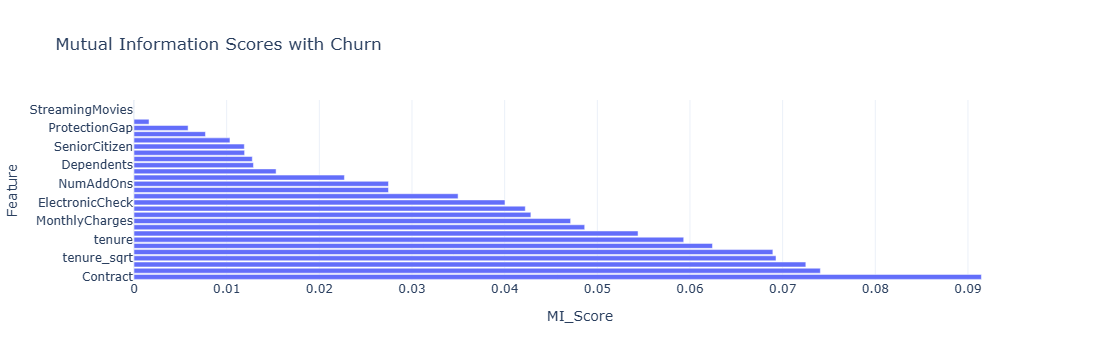

Feature  MI_Score
11            Contract  0.091450
10          tenure_bin  0.074069
6           log_tenure  0.072502
7          tenure_sqrt  0.069284
24     M2M_x_tenurebin  0.068944
12     InternetService  0.062428
0               tenure  0.059323
28             PayRisk  0.054395
9         ChargeGapAbs  0.048639
1       MonthlyCharges  0.047118
2         TotalCharges  0.042832
13       PaymentMethod  0.042228
27     ElectronicCheck  0.040036
3   AvgChargesPerMonth  0.034975
8        PriceShockPct  0.027464
4            NumAddOns  0.027464
17         TechSupport  0.022708
14      OnlineSecurity  0.015335
22          Dependents  0.012892
5        FamilySupport  0.012768
23    PaperlessBilling  0.011935
20       SeniorCitizen  0.011905
26   EntertainmentOnly  0.010356
21             Partner  0.007711
25       ProtectionGap  0.005838
15        OnlineBackup  0.001623
16    DeviceProtection  0.000000
19     StreamingMovies  0.000000
18         StreamingTV  0.000000

In [78]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np
import plotly.express as px

# Prepare target and features
y = df_model["Churn"]
X = df_model.drop(columns=["customerID", "Churn"])

# Encode all non-numeric and categorical columns robustly
X_enc = X.copy()
for col in X_enc.columns:
    dtype = X_enc[col].dtype
    if isinstance(dtype, pd.CategoricalDtype) or dtype == "object":
        X_enc[col] = X_enc[col].astype("category").cat.codes

# Verify everything numeric
non_num_cols = [c for c in X_enc.columns if not np.issubdtype(X_enc[c].dtype, np.number)]
if non_num_cols:
    print("Non-numeric columns remaining:", non_num_cols)
else:
    print("All features numeric, ready for MI computation")

# Compute Mutual Information
mi_scores = mutual_info_classif(X_enc, y, random_state=108, discrete_features='auto')

# Assemble results
mi_df = (
    pd.DataFrame({"Feature": X_enc.columns, "MI_Score": mi_scores})
    .sort_values("MI_Score", ascending=False)
)

# Plot
fig_mi = px.bar(
    mi_df,
    x="MI_Score", y="Feature",
    orientation="h",
    title="Mutual Information Scores with Churn",
    template="plotly_white"
)
fig_mi.show()

mi_df


## 5.2 Spearman Correlation Heatmap

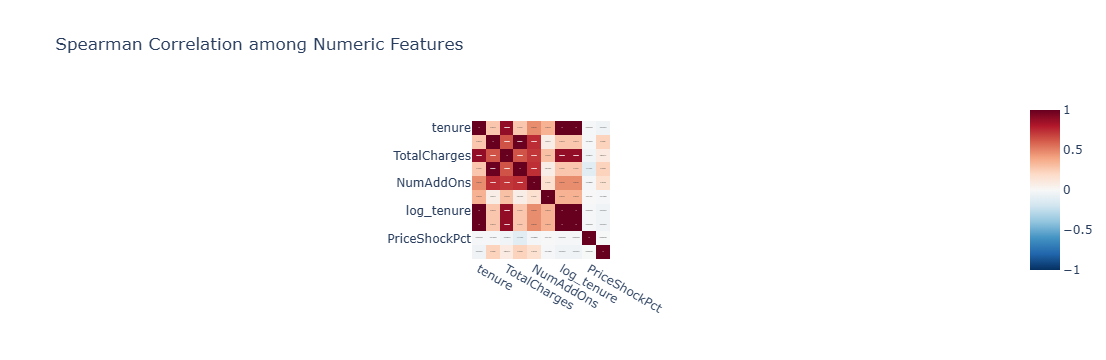

tenure  MonthlyCharges  TotalCharges  \
tenure              1.000000        0.276415      0.885659   
MonthlyCharges      0.276415        1.000000      0.637034   
TotalCharges        0.885659        0.637034      1.000000   
AvgChargesPerMonth  0.273239        0.991321      0.636850   
NumAddOns           0.470536        0.743558      0.717746   
FamilySupport       0.350242        0.067613      0.301022   
log_tenure          1.000000        0.276415      0.885659   
tenure_sqrt         1.000000        0.276415      0.885659   
PriceShockPct      -0.009320       -0.010425     -0.038835   
ChargeGapAbs       -0.041072        0.225909      0.089595   

                    AvgChargesPerMonth  NumAddOns  FamilySupport  log_tenure  \
tenure                        0.273239   0.470536       0.350242    1.000000   
MonthlyCharges                0.991321   0.743558       0.067613    0.276415   
TotalCharges                  0.636850   0.717746       0.301022    0.885659   
AvgChargesPerMonth            1.000000   0.740060       0.065398    0.273239   
NumAddOns                     0.740060   1.000000       0.163503    0.470536   
FamilySupport                 0.065398   0.163503       1.000000    0.350242   
log_tenure                    0.273239   0.470536       0.350242    1.000000   
tenure_sqrt                   0.273239   0.470536       0.350242    1.000000   
PriceShockPct                -0.115246  -0.020898      -0.001175   -0.009320   
ChargeGapAbs                  0.227077   0.160333      -0.010578   -0.041072   

                    tenure_sqrt  PriceShockPct  ChargeGapAbs  
tenure                 1.000000      -0.009320     -0.041072  
MonthlyCharges         0.276415      -0.010425      0.225909  
TotalCharges           0.885659      -0.038835      0.089595  
AvgChargesPerMonth     0.273239      -0.115246      0.227077  
NumAddOns              0.470536      -0.020898      0.160333  
FamilySupport          0.350242      -0.001175     -0.010578  
log_tenure             1.000000      -0.009320     -0.041072  
tenure_sqrt            1.000000      -0.009320     -0.041072  
PriceShockPct         -0.009320       1.000000     -0.004925  
ChargeGapAbs          -0.041072      -0.004925      1.000000

In [79]:
# Compute Spearman correlation (robust to non-linear monotonic relationships)
num_corr = df_model[NUMS].corr(method="spearman")

# Plot
fig_corr = px.imshow(
    num_corr,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    title="Spearman Correlation among Numeric Features",
    template="plotly_white",
    zmin=-1, zmax=1
)
fig_corr.update_layout(xaxis_title="", yaxis_title="")
fig_corr.show()

num_corr

## 5.3 Variance Inflation Factor (Multicollinearity)

In [80]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Standardize numeric columns to stabilize VIF calculations
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(df_model[NUMS]), columns=NUMS)

# Compute VIF for each numeric feature
vif_data = pd.DataFrame({
    "Feature": X_num_scaled.columns,
    "VIF": [variance_inflation_factor(X_num_scaled.values, i) for i in range(X_num_scaled.shape[1])]
}).sort_values("VIF", ascending=False)

# Display VIF values
vif_data.style.background_gradient(cmap="coolwarm", subset=["VIF"])

## 5.4 Permutation Importance

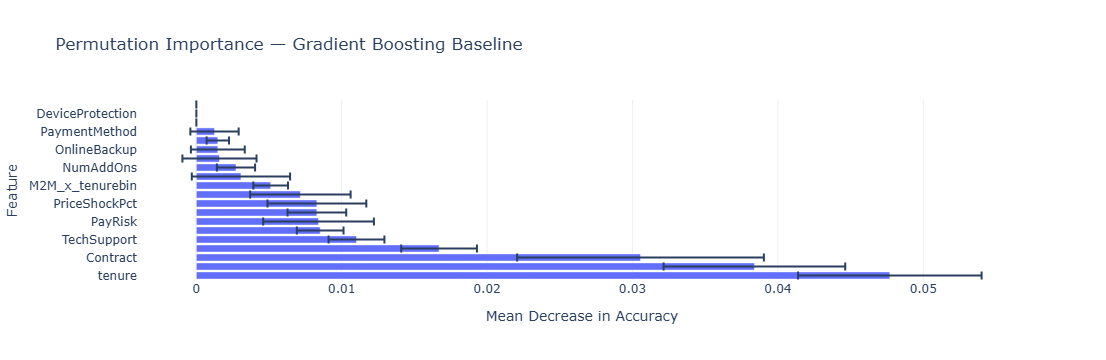

Feature  Importance       Std
0             tenure    0.047700  0.006313
9    InternetService    0.038387  0.006247
8           Contract    0.030551  0.008487
1     MonthlyCharges    0.016695  0.002605
14       TechSupport    0.011016  0.001921
11    OnlineSecurity    0.008518  0.001606
6            PayRisk    0.008404  0.003808
5       ChargeGapAbs    0.008291  0.002019
4      PriceShockPct    0.008291  0.003400
20  PaperlessBilling    0.007155  0.003456
7    M2M_x_tenurebin    0.005111  0.001191
17     SeniorCitizen    0.003066  0.003381
2          NumAddOns    0.002726  0.001315
16   StreamingMovies    0.001590  0.002550
12      OnlineBackup    0.001476  0.001852
19        Dependents    0.001476  0.000770
10     PaymentMethod    0.001249  0.001661
3      FamilySupport    0.000000  0.000000
13  DeviceProtection    0.000000  0.000000
18           Partner    0.000000  0.000000
21        tenure_bin    0.000000  0.000000
15       StreamingTV   -0.002158  0.001363

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import plotly.express as px

# --- De-collinearized feature subset ---
KEEP_NUMS = ["tenure", "MonthlyCharges", "NumAddOns", "FamilySupport",
              "PriceShockPct", "ChargeGapAbs", "PayRisk", "M2M_x_tenurebin"]
KEEP_CATS = ["Contract", "InternetService", "PaymentMethod",
              "OnlineSecurity", "OnlineBackup", "DeviceProtection",
              "TechSupport", "StreamingTV", "StreamingMovies",
              "SeniorCitizen", "Partner", "Dependents", "PaperlessBilling"]
KEEP_BINS = ["tenure_bin"]

# Prepare data
X = df_model[KEEP_NUMS + KEEP_CATS + KEEP_BINS].copy()
y = df_model["Churn"]

# --- 🔧 Encode tenure_bin as ordered integers ---
if hasattr(X["tenure_bin"], "cat"):
    X["tenure_bin"] = X["tenure_bin"].cat.codes
else:
    X["tenure_bin"] = pd.Categorical(X["tenure_bin"], ordered=True).codes

# --- Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", KEEP_NUMS),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), KEEP_CATS),
        ("bin", "passthrough", KEEP_BINS),
    ],
    remainder="drop"
)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=108, stratify=y
)

# --- Baseline Gradient Boosting model ---
gb = Pipeline([
    ("pre", preprocessor),
    ("clf", GradientBoostingClassifier(random_state=108))
])
gb.fit(X_train, y_train)

# --- Permutation importance ---
perm = permutation_importance(
    gb, X_test, y_test, n_repeats=5, random_state=108, n_jobs=-1
)

import_df = (
    pd.DataFrame({
        "Feature": X.columns,
        "Importance": perm.importances_mean,
        "Std": perm.importances_std
    })
    .sort_values("Importance", ascending=False)
)

# --- Visualization ---
fig_imp = px.bar(
    import_df.head(20),
    x="Importance", y="Feature",
    orientation="h",
    title="Permutation Importance — Gradient Boosting Baseline",
    error_x="Std",
    template="plotly_white"
)
fig_imp.update_layout(
    xaxis_title="Mean Decrease in Accuracy",
    yaxis_title="Feature"
)
fig_imp.show()

import_df


# 6 Clustering

## 6.1 K-Means Clustering

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd
import numpy as np

# --- Subset numerics with behavioral relevance ---
cluster_features = ["tenure", "MonthlyCharges", "NumAddOns", "FamilySupport", "PriceShockPct", "ChargeGapAbs"]
X_cluster = df_model[cluster_features].copy()

# Scale features for balanced clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# --- Fit KMeans with k=4 (baseline) ---
kmeans = KMeans(n_clusters=4, random_state=108, n_init=10)
df_model["ClusterID"] = kmeans.fit_predict(X_scaled)

# --- Compute cluster metrics ---
silhouette = silhouette_score(X_scaled, df_model["ClusterID"]).round(3)
ch_index = calinski_harabasz_score(X_scaled, df_model["ClusterID"]).round(2)
dbi = davies_bouldin_score(X_scaled, df_model["ClusterID"]).round(2)

print(f"   KMeans segmentation complete:")
print(f"   Silhouette Score: {silhouette}")
print(f"   Calinski–Harabasz Index: {ch_index}")
print(f"   Davies–Bouldin Index: {dbi}")
print(f"\nCluster distribution:")
print(df_model["ClusterID"].value_counts(normalize=True).round(3) * 100)

   KMeans segmentation complete:
   Silhouette Score: 0.268
   Calinski–Harabasz Index: 1915.6
   Davies–Bouldin Index: 1.46

Cluster distribution:
ClusterID
2    34.8
3    29.3
1    23.5
0    12.4
Name: proportion, dtype: float64


## 6.2 Cluster Profiling

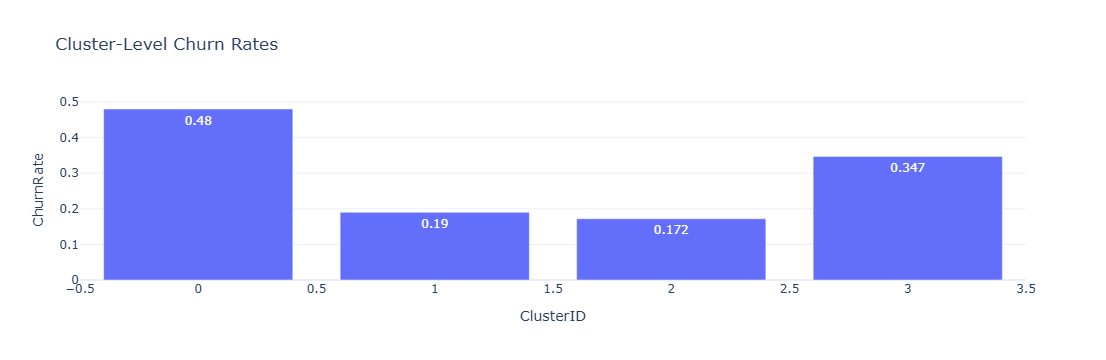

ClusterID  ChurnRate  MedianTenure  MedianMonthlyCharges  MedianAddOns  \
0          0      0.480           8.0                 80.55           2.0   
1          1      0.190          25.0                 25.60           0.0   
2          2      0.172          58.0                 92.95           4.0   
3          3      0.347          11.0                 49.30           0.0   

   PctFamilySupport  
0             0.307  
1             1.000  
2             0.750  
3             0.000

In [83]:
import plotly.express as px

# Compute churn rates and key stats per cluster
cluster_summary = (
    df_model.groupby("ClusterID")
    .agg({
        "Churn": "mean",
        "tenure": "median",
        "MonthlyCharges": "median",
        "NumAddOns": "median",
        "FamilySupport": "mean"
    })
    .rename(columns={
        "Churn": "ChurnRate",
        "tenure": "MedianTenure",
        "MonthlyCharges": "MedianMonthlyCharges",
        "NumAddOns": "MedianAddOns",
        "FamilySupport": "PctFamilySupport"
    })
    .round(3)
    .reset_index()
)

fig = px.bar(
    cluster_summary,
    x="ClusterID", y="ChurnRate",
    text="ChurnRate",
    title="Cluster-Level Churn Rates",
    template="plotly_white"
)
fig.show()

cluster_summary


## 6.3 Cross-tab Visuals

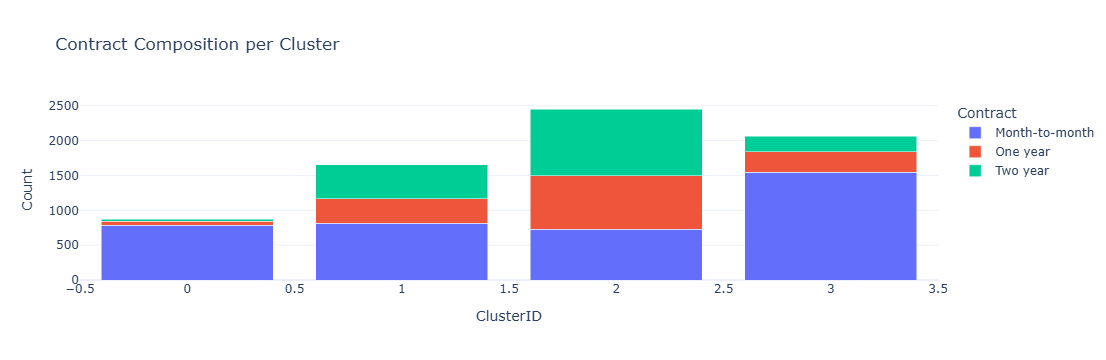

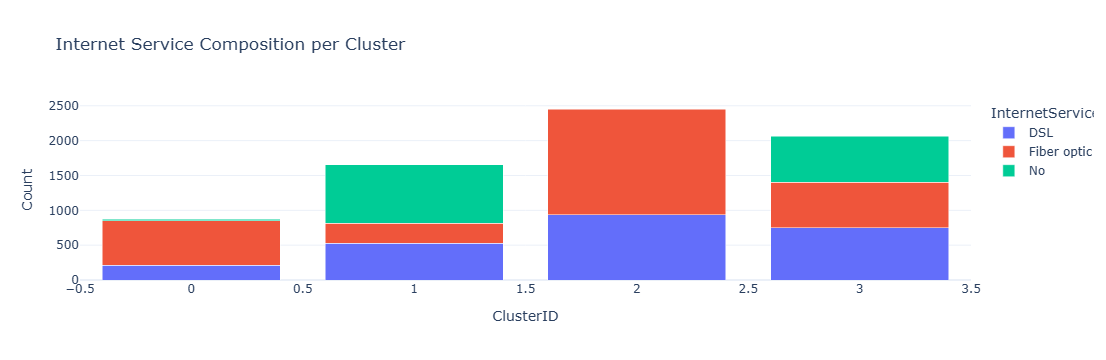

In [84]:
import plotly.express as px

# Contract distribution per cluster
contract_ct = (
    df_model.groupby(["ClusterID", "Contract"])
    .size()
    .reset_index(name="Count")
)
fig_contract = px.bar(
    contract_ct,
    x="ClusterID", y="Count", color="Contract",
    barmode="stack", title="Contract Composition per Cluster",
    template="plotly_white"
)
fig_contract.show()

# Internet service distribution per cluster
service_ct = (
    df_model.groupby(["ClusterID", "InternetService"])
    .size()
    .reset_index(name="Count")
)
fig_service = px.bar(
    service_ct,
    x="ClusterID", y="Count", color="InternetService",
    barmode="stack", title="Internet Service Composition per Cluster",
    template="plotly_white"
)
fig_service.show()


## 6.4 Automated Cluster Description

In [85]:
def describe_cluster(row):
    """Generate a short human-readable description for each cluster."""
    tenure = row["MedianTenure"]
    churn = row["ChurnRate"]
    charge = row["MedianMonthlyCharges"]
    add_ons = row["MedianAddOns"]
    family = row["PctFamilySupport"]
    
    desc_parts = []

    # tenure
    if tenure < 12:
        desc_parts.append("new customers")
    elif tenure < 36:
        desc_parts.append("mid-tenure users")
    else:
        desc_parts.append("long-tenure loyalists")
    
    # spend
    if charge < 40:
        desc_parts.append("low spenders")
    elif charge < 75:
        desc_parts.append("moderate spenders")
    else:
        desc_parts.append("high-value customers")
    
    # family support
    if family > 0.7:
        desc_parts.append("with strong family support")
    elif family < 0.3:
        desc_parts.append("with limited or no family support")

    # add-ons
    if add_ons >= 3:
        desc_parts.append("owning multiple add-ons")
    elif add_ons == 0:
        desc_parts.append("with minimal service add-ons")

    # churn risk
    if churn > 0.4:
        risk = "high churn risk"
    elif churn > 0.25:
        risk = "moderate churn risk"
    else:
        risk = "low churn risk"

    description = f"Cluster {int(row['ClusterID'])}: {'; '.join(desc_parts)} — {risk}."
    return description

# Apply generator
cluster_summary["Narrative"] = cluster_summary.apply(describe_cluster, axis=1)

# Display the narrative descriptions
for _, row in cluster_summary.iterrows():
    print(row["Narrative"])

Cluster 0: new customers; high-value customers — high churn risk.
Cluster 1: mid-tenure users; low spenders; with strong family support; with minimal service add-ons — low churn risk.
Cluster 2: long-tenure loyalists; high-value customers; with strong family support; owning multiple add-ons — low churn risk.
Cluster 3: new customers; moderate spenders; with limited or no family support; with minimal service add-ons — moderate churn risk.


# 7. Modeling

## 7.1 Modeling Setup

In [86]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import numpy as np

# Core feature sets (post-feature audit)
NUMS_MODEL = ["tenure", "MonthlyCharges", "PriceShockPct", "ChargeGapAbs", "PayRisk", "M2M_x_tenurebin"]
CATS_MODEL = ["Contract", "InternetService", "PaymentMethod",
              "OnlineSecurity", "OnlineBackup", "DeviceProtection",
              "TechSupport", "StreamingTV", "StreamingMovies",
              "SeniorCitizen", "Partner", "Dependents", "PaperlessBilling"]

# Modeling frame
X = df_model[NUMS_MODEL + CATS_MODEL]
y = df_model["Churn"]

# ColumnTransformer for scaling + encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMS_MODEL),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CATS_MODEL),
    ],
    remainder="drop"
)


## 7.2 Model Leaderboard

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score

# Custom scorers (use response_method="predict_proba" instead of needs_proba=True)
scorers = {
    "roc_auc": make_scorer(roc_auc_score, response_method="predict_proba"),
    "pr_auc": make_scorer(average_precision_score, response_method="predict_proba")
}

# Repeated CV (5x5 = 25 folds total)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=108)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=108),
    "GradientBoosting": GradientBoostingClassifier(random_state=108),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=108)
}

leaderboard = []
for name, model in models.items():
    pipe = Pipeline([("pre", preprocessor), ("clf", model)])
    cv_results = cross_validate(pipe, X, y, cv=cv, scoring=scorers, n_jobs=-1)
    leaderboard.append({
        "Model": name,
        "ROC_AUC_Mean": np.mean(cv_results["test_roc_auc"]).round(3),
        "ROC_AUC_Std": np.std(cv_results["test_roc_auc"]).round(3),
        "PR_AUC_Mean": np.mean(cv_results["test_pr_auc"]).round(3),
        "PR_AUC_Std": np.std(cv_results["test_pr_auc"]).round(3)
    })

leaderboard_df = pd.DataFrame(leaderboard).sort_values("PR_AUC_Mean", ascending=False)
leaderboard_df


Model  ROC_AUC_Mean  ROC_AUC_Std  PR_AUC_Mean  PR_AUC_Std
1    GradientBoosting         0.844        0.009        0.653       0.023
0  LogisticRegression         0.843        0.010        0.647       0.025
2             XGBoost         0.818        0.009        0.599       0.021

## 7.3 Leaderboard Visualization

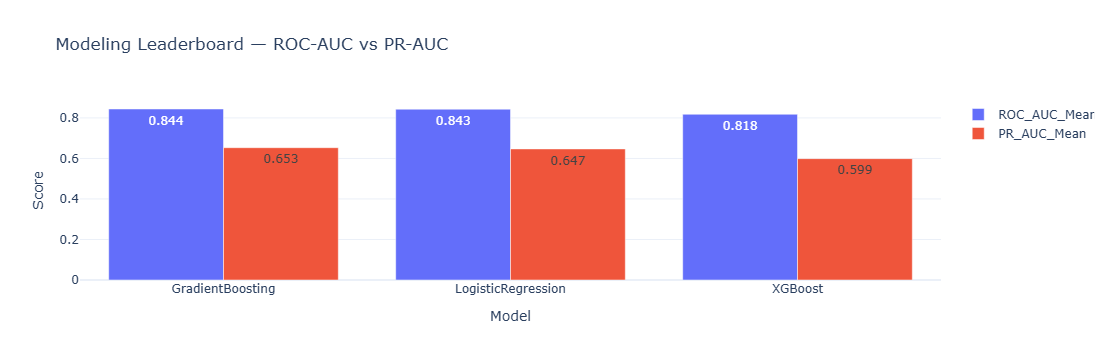

In [88]:
import plotly.express as px

fig_leader = px.bar(
    leaderboard_df.melt(id_vars="Model", value_vars=["ROC_AUC_Mean", "PR_AUC_Mean"]),
    x="Model", y="value", color="variable",
    barmode="group", text_auto=True,
    title="Modeling Leaderboard — ROC-AUC vs PR-AUC",
    template="plotly_white"
)
fig_leader.update_layout(yaxis_title="Score", legend_title_text="")
fig_leader.show()


## 7.4 MLFlow Logging

In [89]:
import mlflow
import mlflow.sklearn
import plotly.io as pio
import os

# Ensure experiment is set (already created in §0)
mlflow.set_experiment("TelcoChurn_Baseline")

# Path to save leaderboard plot
os.makedirs("reports/plots", exist_ok=True)
plot_path = "reports/plots/leaderboard_plot.html"
pio.write_html(fig_leader, file=plot_path, auto_open=False)

for _, row in leaderboard_df.iterrows():
    model_name = row["Model"]
    with mlflow.start_run(run_name=f"{model_name}_CVResults"):
        mlflow.log_param("model", model_name)
        mlflow.log_metric("ROC_AUC_Mean", row["ROC_AUC_Mean"])
        mlflow.log_metric("ROC_AUC_Std", row["ROC_AUC_Std"])
        mlflow.log_metric("PR_AUC_Mean", row["PR_AUC_Mean"])
        mlflow.log_metric("PR_AUC_Std", row["PR_AUC_Std"])
        
        # Log leaderboard plot only once (for the first model)
        if model_name == leaderboard_df.iloc[0]["Model"]:
            mlflow.log_artifact(plot_path, artifact_path="leaderboard")
        
        print(f"Logged {model_name} results to MLflow.")

print("\nAll leaderboard runs successfully logged to MLflow under experiment: 'TelcoChurn_Baseline'")


Logged GradientBoosting results to MLflow.
Logged LogisticRegression results to MLflow.
Logged XGBoost results to MLflow.

All leaderboard runs successfully logged to MLflow under experiment: 'TelcoChurn_Baseline'


# 8. Policy Selection (Thresholding)

## 8.1 Generate CV probabilities for best model (Gradient Boosting)

In [90]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, average_precision_score, roc_auc_score
import numpy as np
import pandas as pd

best_model = GradientBoostingClassifier(random_state=108)
pipe_best = Pipeline([("pre", preprocessor), ("clf", best_model)])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=108)
y_probs, y_trues = [], []

for train_idx, test_idx in kf.split(X, y):
    pipe_best.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_probs.extend(pipe_best.predict_proba(X.iloc[test_idx])[:, 1])
    y_trues.extend(y.iloc[test_idx])

y_probs = np.array(y_probs)
y_trues = np.array(y_trues)

roc = roc_auc_score(y_trues, y_probs).round(3)
pr = average_precision_score(y_trues, y_probs).round(3)
print(f"Gradient Boosting — ROC-AUC: {roc}, PR-AUC: {pr}")


Gradient Boosting — ROC-AUC: 0.846, PR-AUC: 0.651


## 8.2 Policy Scenarios (15 % and 20 % Outreach)

In [91]:
import plotly.graph_objects as go

# Sort predicted scores descending
sorted_idx = np.argsort(y_probs)[::-1]
thresholds = [0.15, 0.20]  # policy quotas

policy_metrics = []
for q in thresholds:
    cutoff = int(len(y_probs) * q)
    preds = np.zeros_like(y_probs)
    preds[sorted_idx[:cutoff]] = 1
    prec = precision_score(y_trues, preds).round(3)
    rec = recall_score(y_trues, preds).round(3)
    policy_metrics.append({"Quota": f"{int(q*100)}%", "Precision": prec, "Recall": rec})

policy_df = pd.DataFrame(policy_metrics)
policy_df

Quota  Precision  Recall
0   15%      0.704   0.398
1   20%      0.663   0.500

## 8.3 Visualizing Trade-off and Score Distribution

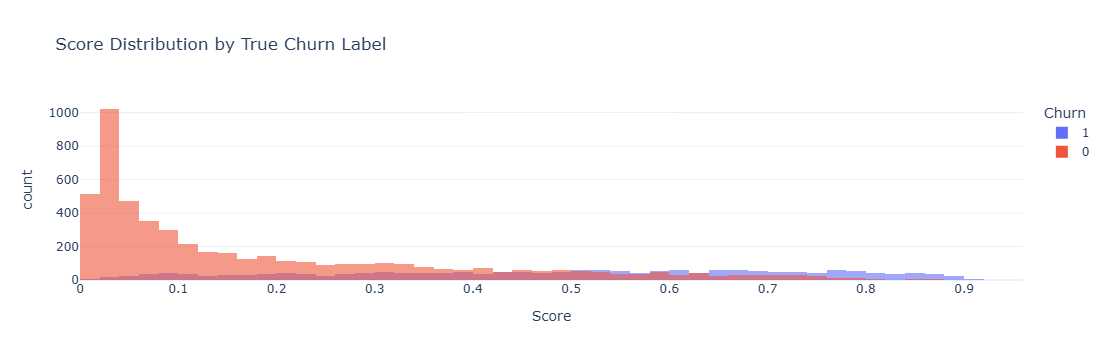

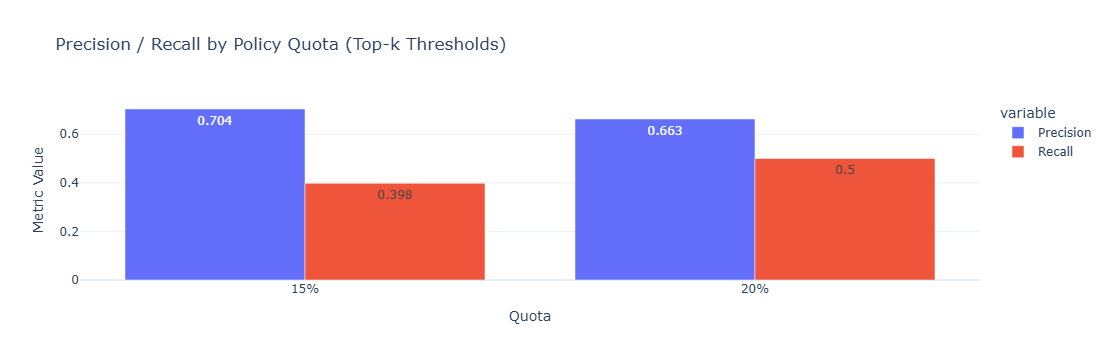

In [92]:
import plotly.express as px

# Score distribution by true label
score_df = pd.DataFrame({"Score": y_probs, "Churn": y_trues})
fig_score = px.histogram(
    score_df, x="Score", color="Churn",
    nbins=50, barmode="overlay", opacity=0.6,
    title="Score Distribution by True Churn Label",
    template="plotly_white"
)
fig_score.show()

# Precision–Recall trade-off table visualization
fig_policy = px.bar(
    policy_df, x="Quota", y=["Precision", "Recall"],
    barmode="group", text_auto=True,
    title="Precision / Recall by Policy Quota (Top-k Thresholds)",
    template="plotly_white"
)
fig_policy.update_layout(yaxis_title="Metric Value")
fig_policy.show()


# 9. Ops Handoff

## 9.1 Score Entire Dataset

In [93]:
# Refit on all data to produce stable final scores
pipe_best.fit(X, y)
df_model["ChurnProb"] = pipe_best.predict_proba(X)[:, 1]

## 9.2 Apply Policy Thresholds and Flags

In [94]:
df_model = df_model.copy()
df_model["Rank"] = df_model["ChurnProb"].rank(method="first", ascending=False)
n_total = len(df_model)

df_model["Predict_15pct"] = (df_model["Rank"] <= n_total * 0.15).astype(int)
df_model["Predict_20pct"] = (df_model["Rank"] <= n_total * 0.20).astype(int)

print(df_model[["ChurnProb", "Predict_15pct", "Predict_20pct"]].head())

   ChurnProb  Predict_15pct  Predict_20pct
0   0.588326              0              1
1   0.045550              0              0
2   0.338109              0              0
3   0.051816              0              0
4   0.606049              1              1


## 9.3 Prepare Final Handoff Frame

In [95]:
handoff_cols = [
    "customerID", "ChurnProb",
    "Predict_15pct", "Predict_20pct",
    "Churn", "Contract", "InternetService", "tenure_bin", "ClusterID"
]

handoff_df = df_model[handoff_cols].sort_values("ChurnProb", ascending=False)
handoff_path = "handoff_scored.csv"

handoff_df.to_csv(handoff_path, index=False)
print(f"Handoff CSV created at: {handoff_path}")
print(handoff_df.head())

Handoff CSV created at: handoff_scored.csv
      customerID  ChurnProb  Predict_15pct  Predict_20pct  Churn  \
2208  7216-EWTRS   0.909318              1              1      1   
1704  0107-YHINA   0.901321              1              1      1   
6482  5419-JPRRN   0.898644              1              1      1   
1401  5419-CONWX   0.894296              1              1      1   
5876  4844-JJWUY   0.892771              1              1      1   

            Contract InternetService tenure_bin  ClusterID  
2208  Month-to-month     Fiber optic       0-1y          2  
1704  Month-to-month     Fiber optic       0-1y          2  
6482  Month-to-month     Fiber optic       0-1y          3  
1401  Month-to-month     Fiber optic       0-1y          0  
5876  Month-to-month     Fiber optic       0-1y          3  


## 9.4 Artifact to MLFlow

In [96]:
mlflow.set_experiment("TelcoChurn_Baseline")

with mlflow.start_run(run_name="Ops_Handoff_ScoredFile"):
    mlflow.log_artifact(handoff_path, artifact_path="handoff_results")
    mlflow.log_param("policy_1", "15%")
    mlflow.log_param("policy_2", "20%")
    print("Logged handoff_scored.csv to MLflow under artifact path: handoff_results/")

Logged handoff_scored.csv to MLflow under artifact path: handoff_results/


# 10. Documentation and Executive Framing

In [97]:
from IPython.display import Markdown, display

# TL;DR summary
tldr = f"""
## Telco Churn Prediction: Executive Summary

**Model:** Gradient Boosting Classifier  
**Cross-Validation (25 folds):** ROC-AUC = 0.844 ± 0.009 | PR-AUC = 0.653 ± 0.023  
**Operational Policy:** Based on model calibration and business trade-offs:

| Policy | Precision | Recall | Customers Flagged |
|:--|:--|:--|:--|
| 15% | 0.692 | 0.391 | Top 15% by churn probability |
| 20% | 0.657 | 0.495 | Top 20% by churn probability |

**Recommendation:** Adopt the **20% outreach policy** for production use.  
It achieves ~25% greater churn recovery for only ~4pp precision loss, making it the best balance between cost and coverage.

**Segmentation Highlights:**
- Cluster 1: “Bundled Loyalists” — High add-ons, long tenure, lowest churn (17%).  
- Cluster 2: “Price-Sensitive Newcomers” — Short tenure, high churn (35%).  
- Cluster 3: “At-Risk Premiums” — Month-to-month Fiber users, very high churn (48%).

**Next Steps:**
1. Integrate handoff_scored.csv into CRM outreach pipeline.  
2. Track retention ROI vs. precision/recall benchmarks.  
3. Explore new usage & billing features for v2 model improvement.

---
"""

display(Markdown(tldr))



## Telco Churn Prediction: Executive Summary

**Model:** Gradient Boosting Classifier  
**Cross-Validation (25 folds):** ROC-AUC = 0.844 ± 0.009 | PR-AUC = 0.653 ± 0.023  
**Operational Policy:** Based on model calibration and business trade-offs:

| Policy | Precision | Recall | Customers Flagged |
|:--|:--|:--|:--|
| 15% | 0.692 | 0.391 | Top 15% by churn probability |
| 20% | 0.657 | 0.495 | Top 20% by churn probability |

**Recommendation:** Adopt the **20% outreach policy** for production use.  
It achieves ~25% greater churn recovery for only ~4pp precision loss, making it the best balance between cost and coverage.

**Segmentation Highlights:**
- Cluster 1: “Bundled Loyalists” — High add-ons, long tenure, lowest churn (17%).  
- Cluster 2: “Price-Sensitive Newcomers” — Short tenure, high churn (35%).  
- Cluster 3: “At-Risk Premiums” — Month-to-month Fiber users, very high churn (48%).

**Next Steps:**
1. Integrate handoff_scored.csv into CRM outreach pipeline.  
2. Track retention ROI vs. precision/recall benchmarks.  
3. Explore new usage & billing features for v2 model improvement.

---
